# In this notebook a LogisticRegression model for each type of layer is trained and evaluated.

This is useful to understand which layers are more suitable for the hallucination detection task.

In [5]:
import json
import os
import numpy as np
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import gc
from sklearn.metrics import f1_score, accuracy_score




In [6]:

PROJECT_ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
CACHE_DIR_NAME = "activation_cache"
HF_DEFAULT_HOME = os.environ.get("HF_HOME", "~\\.cache\\huggingface\\hub")


In [7]:
def stats_per_json(model_name, dataset_name):
    file_path = os.path.join(PROJECT_ROOT, CACHE_DIR_NAME, model_name, dataset_name,"generations","hallucination_labels.json")
    with open(file_path, 'r') as file:
        data = json.load(file)
    total = len(data)
    hallucinations = sum(1 for item in data if item['is_hallucination'])
    percent_hallucinations = (hallucinations / total) * 100 if total > 0 else 0
    allucinated_items = [item['instance_id'] for item in data if item['is_hallucination']]
    return {
        'total': total,
        'hallucinations': hallucinations,
        'percent_hallucinations': percent_hallucinations,
        'hallucinated_items': allucinated_items,
        'model_name': model_name,
        'dataset_name': dataset_name
    }

In [8]:
qwen_stats=stats_per_json("Qwen2.5-7B", "belief_bank")
falcon_stats=stats_per_json("Falcon3-7B-Base", "belief_bank")
print("Qwen2.5-7B Hallucination Stats:", qwen_stats)
print("Falcon-7B Hallucination Stats:", falcon_stats)
common_hallucinated = set(item for item in qwen_stats['hallucinated_items']).intersection(
    set(item for item in falcon_stats['hallucinated_items'])
)
print("Number of common hallucinated instances between Qwen2.5-7B and Falcon-7B:", len(common_hallucinated))

Qwen2.5-7B Hallucination Stats: {'total': 27416, 'hallucinations': 15728, 'percent_hallucinations': 57.36796031514444, 'hallucinated_items': [5, 9, 10, 14, 35, 42, 55, 63, 65, 68, 72, 74, 83, 85, 93, 95, 117, 119, 128, 144, 148, 150, 156, 165, 167, 168, 169, 174, 175, 177, 178, 180, 185, 186, 189, 190, 191, 195, 196, 199, 201, 204, 205, 206, 207, 209, 212, 213, 214, 218, 219, 220, 223, 224, 225, 226, 230, 231, 232, 235, 238, 241, 245, 248, 252, 257, 264, 267, 268, 269, 272, 274, 276, 280, 281, 285, 286, 288, 291, 295, 300, 302, 303, 310, 320, 322, 327, 329, 333, 335, 336, 338, 347, 351, 358, 370, 374, 386, 387, 393, 396, 398, 399, 400, 401, 402, 406, 411, 412, 415, 418, 427, 430, 439, 440, 445, 446, 450, 456, 458, 466, 469, 474, 477, 480, 481, 482, 483, 485, 487, 495, 505, 508, 509, 511, 515, 518, 519, 525, 526, 528, 533, 535, 536, 537, 540, 541, 542, 543, 544, 547, 548, 549, 550, 551, 553, 554, 555, 556, 557, 558, 560, 562, 566, 569, 570, 571, 572, 573, 574, 575, 576, 578, 580, 581, 5

In [9]:
def layers_in_model(model):
    file_path = os.path.join(PROJECT_ROOT, CACHE_DIR_NAME, model)
    #open the first subdirectory found in file_path
    subdirs = [d for d in os.listdir(file_path) if os.path.isdir(os.path.join(file_path, d))]
    if not subdirs:
        raise ValueError(f"No subdirectories found in {file_path}")
    first_subdir = subdirs[0]
    layer_files = os.path.join(file_path,first_subdir, "activation_attn")
    #return number of files / 2
    return len(os.listdir(layer_files)) // 2



In [10]:
models={
    "Qwen2.5-7B": qwen_stats,
    "Falcon3-7B-Base": falcon_stats
}
n_samples = qwen_stats['total'] 
rng = np.random.RandomState(42)
shuffled_indices = rng.permutation(n_samples)
split_idx = int(0.7 * n_samples)

train_indices = shuffled_indices[:split_idx]
test_indices = shuffled_indices[split_idx:]

# Organizzazione gerarchica dei risultati
results = {
    "Qwen2.5-7B": {"attn": {}, "mlp": {}, "hidden": {}},
    "Falcon3-7B-Base": {"attn": {}, "mlp": {}, "hidden": {}}
}
y = None
for dataset in ["belief_bank"]:
    for model in ["Qwen2.5-7B", "Falcon3-7B-Base"]:
        num_layers = layers_in_model(model)
        for layer in range(num_layers):
            for layer_type in ["attn", "mlp","hidden"]:
                #load the cached activations
                file_path = os.path.join(PROJECT_ROOT, CACHE_DIR_NAME, model, dataset, "activation_"+layer_type, f"layer{layer}_activations.pt")
                activations = torch.load(file_path)
                if isinstance(activations, torch.Tensor):
                    X_layer = activations.cpu().numpy().astype(np.float32)
                else:
                    X_layer = activations.astype(np.float32)
                if y is None:
                    y = np.zeros(X_layer.shape[0], dtype=int)
                    for i in range(len(y)):
                        if i in models[model]['hallucinated_items']:
                            y[i] = 1
                #Train a Logistic Regression model
                X_train = X_layer[train_indices]
                y_train = y[train_indices]
                X_test = X_layer[test_indices]
                y_test = y[test_indices]
                scaler= StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
                print(f"Training Logistic Regression for {model} - Layer {layer} - Type {layer_type}")
                clf = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs', n_jobs=-1)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)
                
                # Salva i risultati in formato (accuracy, f1)
                results[model][layer_type][layer] = (accuracy, f1)
                
                #Free memory
                del activations
                del X_layer
                gc.collect()
                torch.cuda.empty_cache()



                


Training Logistic Regression for Qwen2.5-7B - Layer 0 - Type attn
Training Logistic Regression for Qwen2.5-7B - Layer 0 - Type mlp
Training Logistic Regression for Qwen2.5-7B - Layer 0 - Type hidden
Training Logistic Regression for Qwen2.5-7B - Layer 1 - Type attn
Training Logistic Regression for Qwen2.5-7B - Layer 1 - Type mlp
Training Logistic Regression for Qwen2.5-7B - Layer 1 - Type hidden
Training Logistic Regression for Qwen2.5-7B - Layer 2 - Type attn
Training Logistic Regression for Qwen2.5-7B - Layer 2 - Type mlp
Training Logistic Regression for Qwen2.5-7B - Layer 2 - Type hidden
Training Logistic Regression for Qwen2.5-7B - Layer 3 - Type attn
Training Logistic Regression for Qwen2.5-7B - Layer 3 - Type mlp
Training Logistic Regression for Qwen2.5-7B - Layer 3 - Type hidden
Training Logistic Regression for Qwen2.5-7B - Layer 4 - Type attn
Training Logistic Regression for Qwen2.5-7B - Layer 4 - Type mlp
Training Logistic Regression for Qwen2.5-7B - Layer 4 - Type hidden
Train

In [11]:
# Funzione per ordinare tutti i layer per accuracy e salvare su JSON
def sort_and_save_all_results(results, output_file="sorted_results.json"):
    """
    Ordina tutti i layer per accuracy in ordine decrescente e salva su JSON.
    
    Args:
        results: dizionario completo dei risultati nel formato:
                 {model_name: {layer_type: {layer_num: (accuracy, f1)}}}
        output_file: path del file JSON di output
    
    Returns:
        dizionario con tutti i risultati ordinati
    """
    sorted_results = {}
    
    for model_name, layer_types in results.items():
        sorted_results[model_name] = {}
        
        for layer_type, layer_data in layer_types.items():
            # Ordina i layer per accuracy decrescente
            sorted_layers = sorted(
                [(layer, acc, f1) for layer, (acc, f1) in layer_data.items()],
                key=lambda x: x[1],  # ordina per accuracy
                reverse=True  # ordine decrescente
            )
            
            # Salva in formato lista ordinata
            sorted_results[model_name][layer_type] = [
                {
                    "layer": layer,
                    "accuracy": acc,
                    "f1_score": f1
                }
                for layer, acc, f1 in sorted_layers
            ]
    
    # Salva su JSON
    with open(output_file, 'w') as f:
        json.dump(sorted_results, f, indent=4)
    print(f"Tutti i risultati ordinati salvati in {output_file}")
    
    return sorted_results

# Esempio di utilizzo: salva tutti i risultati ordinati
sorted_all = sort_and_save_all_results(results, "all_layers_sorted.json")

Tutti i risultati ordinati salvati in all_layers_sorted.json


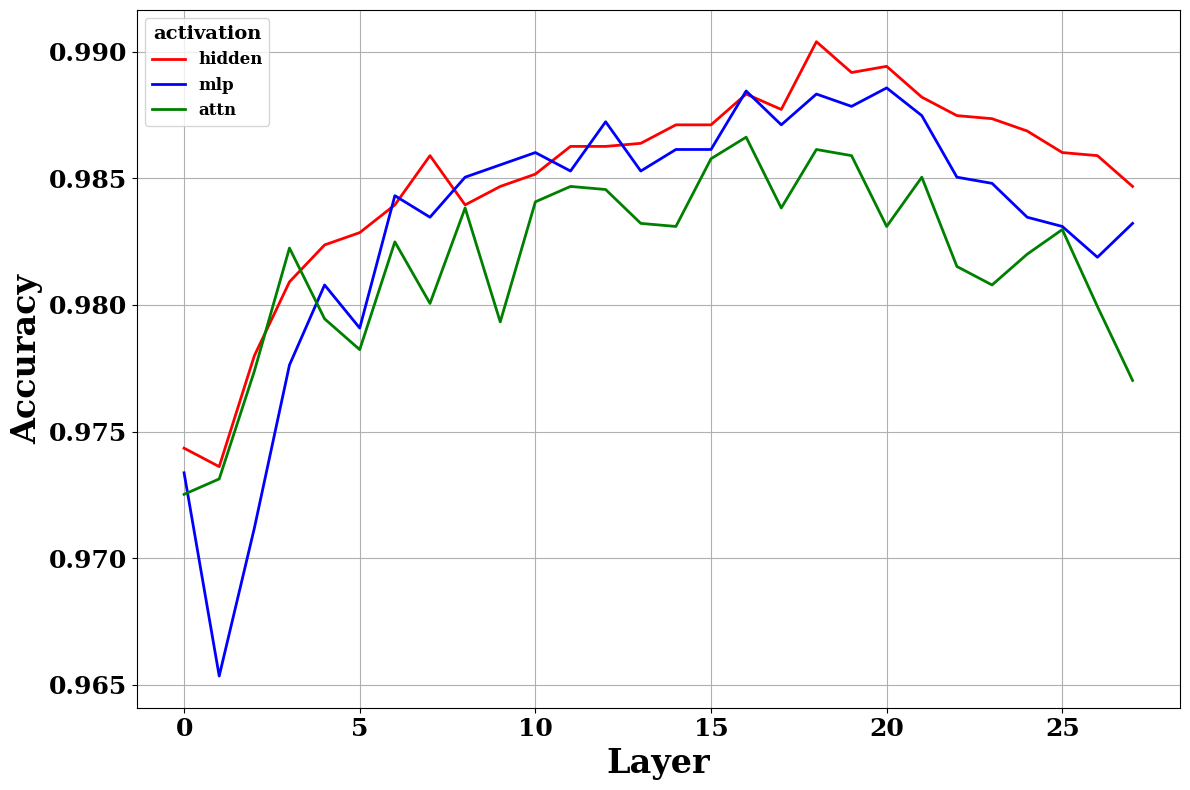

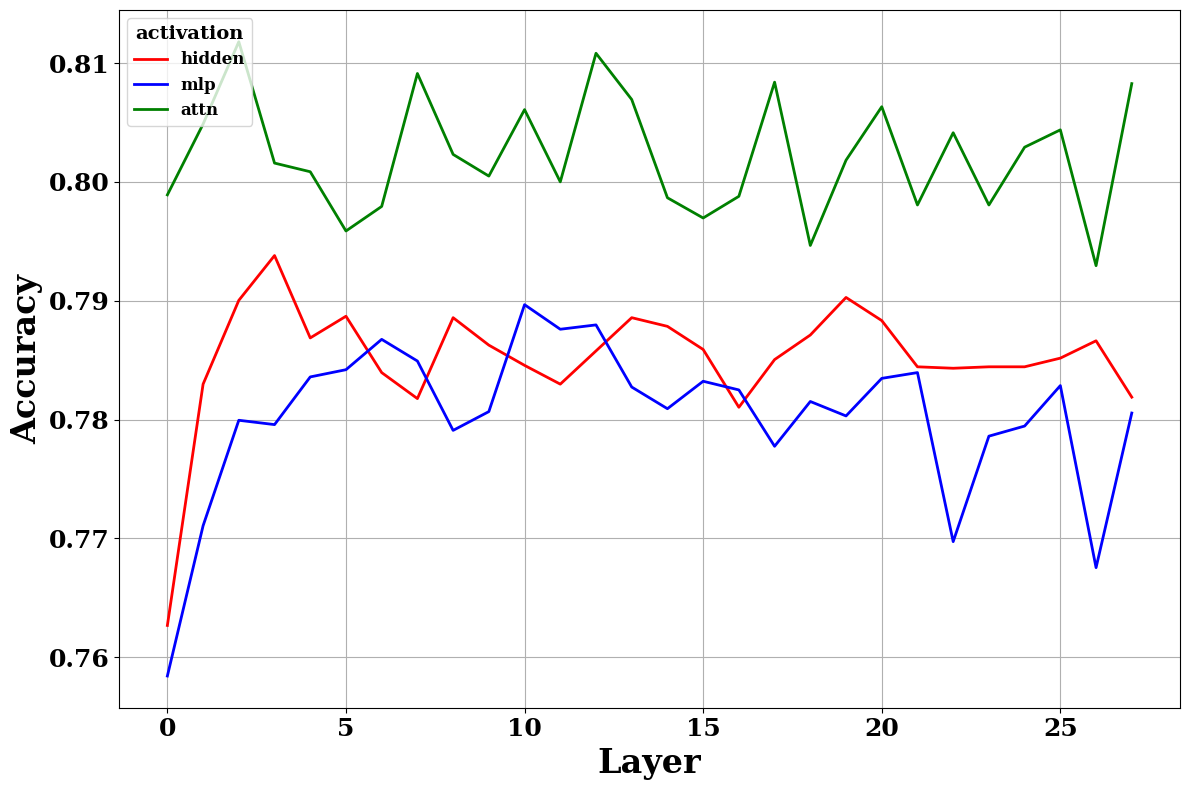

In [6]:
import matplotlib.pyplot as plt
import json

def plot_accuracy_from_json(json_data, model_name=None,dataset="Dat"):
    """
    Genera un grafico dell'accuracy per layer simile all'immagine fornita.
    
    Args:
        json_data (dict): Il dizionario caricato dal file JSON.
        model_name (str): Il nome del modello da plottare (es. "Qwen2.5-7B"). 
                          Se None, prende il primo modello trovato nel JSON.
    """
    
    # 1. Selezione del modello
    if model_name is None:
        model_name = list(json_data.keys())[0]
    
    if model_name not in json_data:
        print(f"Errore: Modello '{model_name}' non trovato nel JSON.")
        return

    data = json_data[model_name]

    # 2. Configurazione dello Stile (replicando l'immagine)
    plt.rcParams.update({
        "font.family": "serif",           # Font simile a Times New Roman
        "font.weight": "bold",            # Testo in grassetto
        "axes.labelweight": "bold",       # Etichette assi in grassetto
        "axes.labelsize": 24,             # Dimensione etichette assi (grande)
        "xtick.labelsize": 18,            # Dimensione numeri asse X
        "ytick.labelsize": 18,            # Dimensione numeri asse Y
        "legend.fontsize": 12,            # Ridotta: dimensione testo legenda
        "legend.title_fontsize": 14,      # Ridotta: dimensione titolo legenda
        "lines.linewidth": 2              # Spessore linee
    })

    # Creazione della figura
    fig, ax = plt.subplots(figsize=(12, 8))

    # Mappatura colori e ordine come nell'immagine
    # hidden -> rosso, mlp -> blu, attn -> verde
    styles = {
        "hidden": {"color": "red", "label": "hidden"},
        "mlp":    {"color": "blue", "label": "mlp"},
        "attn":   {"color": "green", "label": "attn"}
    }

    # 3. Estrazione e Ordinamento dei dati
    # L'immagine mostra l'ordine di plot specifico, ma iteriamo sulle chiavi
    for key in ["hidden", "mlp", "attn"]:
        if key in data:
            points = data[key]
            
            # PASSAGGIO CRUCIALE: Il JSON non è ordinato per layer.
            # Dobbiamo ordinare la lista di dizionari basandoci sulla chiave 'layer'
            sorted_points = sorted(points, key=lambda x: x['layer'])
            
            # Estrazione X (layer) e Y (accuracy)
            layers = [item['layer'] for item in sorted_points]
            accuracies = [item['accuracy'] for item in sorted_points]
            
            # Plotting
            ax.plot(layers, accuracies, 
                    color=styles[key]["color"], 
                    label=styles[key]["label"])

    # 4. Rifinitura Grafica
    ax.set_xlabel("Layer")
    ax.set_ylabel("Accuracy")
    
    # Griglia
    ax.grid(True, linestyle='-', alpha=1.0) # Griglia solida come nell'immagine
    
    # Legenda personalizzata in alto a sinistra (font ridotto)
    legend = ax.legend(title="activation", loc="upper left", frameon=True)
    # Titolo in grassetto ma più piccolo
    plt.setp(legend.get_title(), fontweight='bold')
    # Assicuriamoci che i testi della legenda abbiano la dimensione impostata (compatibilità)
    try:
        legend.get_title().set_fontsize(plt.rcParams["legend.title_fontsize"])
        for t in legend.get_texts():
            t.set_fontsize(plt.rcParams["legend.fontsize"])
    except Exception:
        pass

    plt.tight_layout()
    plt.savefig(f"img/{model_name}_{dataset}_activations.png")
    plt.show()

# Esempio di utilizzo:

content = json.load(open('all_layers_sorted.json'))
plot_accuracy_from_json(content, "Qwen2.5-7B","BeliefBank")
plot_accuracy_from_json(content, "Falcon3-7B-Base","BeliefBank")